In [1]:
print("Hello World")

Hello World


In [1]:
import torch
import numpy as np

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [15]:
#num of subprocesses to use for data loading
num_workers = 0
batch_size = 640
#validation percentage
valid_size = 0.2

In [16]:
transform = transforms.ToTensor()

train_data = datasets.EMNIST(root = 'MNIST_data', 
                             split = 'byclass',
                             train=True,
                             download=True,
                             transform=transform)
test_data = datasets.EMNIST(root = 'MNIST_data', 
                             split = 'byclass',
                             train=False,
                             download=True,
                             transform=transform)

In [17]:
#get indices for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [18]:
#define samplers for obtaining batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [19]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, 
                                           num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)

<h2><b>Visualise data</b></h2>

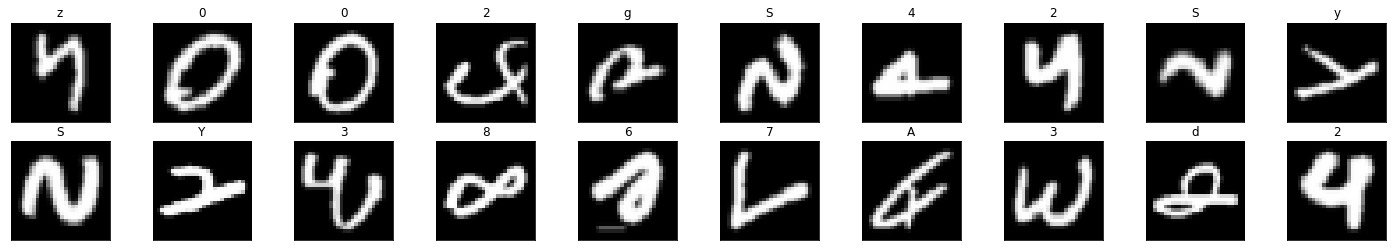

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

#dict for number to letter
letters = {10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N',
          24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a', 37:'b', 
           38:'c', 39:'d', 40:'e', 41:'f', 42:'g', 43:'h', 44:'i', 45:'j', 46:'k', 47:'k', 48:'m', 49:'n', 50:'o', 
           51:'p', 52:'q', 53:'r', 54:'s', 55:'t', 56:'u', 57:'v', 58:'w', 59:'x', 60:'y', 61:'z'}

#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()) if labels[idx]<10 else letters[labels[idx].item()])

<h2><b>View image in more detail</b></h2>

(28, 28)


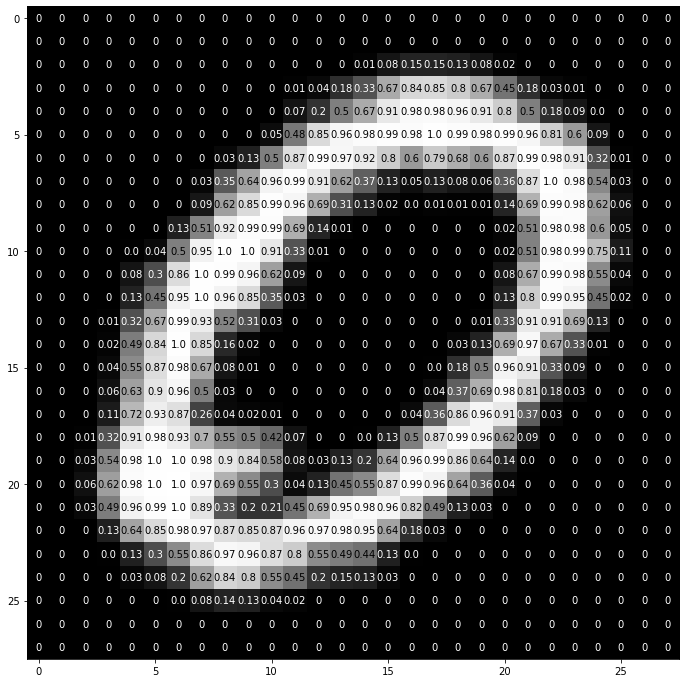

In [21]:
img = np.squeeze(images[1])
print(img.shape)
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y].item(), 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment = 'center',
                   verticalalignment = 'center',
                   color = 'white' if img[x][y]<thresh else 'black')

<h2><b>Define Architecture</b></h2>

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop = 0.2
        
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=16, 
            kernel_size=3, 
            padding=1)
        
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32, 
            kernel_size=3, 
            padding=1)
        
        self.conv3 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=3, 
            padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*3*3, 400)
        self.fc2 = nn.Linear(400, 62)
        
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        
        x = x.view(-1, 64*3*3)
        
        x = self.dropout(x)
        x = F.tanh(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = Net().cuda()
print(model)
        

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=62, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<h2><b>Specify Loss and Optimization Functions</b></h2>

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)

<h2><b>(Optional)Load weights if you want to retrain model</b></h2>

In [50]:
model.load_state_dict(torch.load('model_EMNIST_CNN.pt'))

<All keys matched successfully>

<h2><b>Train Network</b></h2>


Steps:
<ul>
<li>Clear grads</li>
<li>Forward prop</li>
<li>Loss calc</li>
<li>Back prop</li>
<li>Optimization step</li>
<li>Update average training loss</li>
</ul>

In [51]:
epochs = 50
#init min validation loss
valid_loss_min = np.Inf

for epoch in range(epochs):
    batch_num=0

    train_loss = 0.0
    valid_loss = 0.0

    train_acc=0.0
    val_acc=0.0
    
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        batch_num+=1
    
    model.eval()
    for data, target in valid_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss+=loss.item()*data.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1,
        train_acc/batch_num * 100,
        val_acc/batch_num * 100
    ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_EMNIST_CNN.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.414087 	Validation Loss: 0.377965
Epoch: 1 	Training Accuracy: 85.046061 	Validation Accuracy: 21.645194
Validation loss decreased (inf --> 0.377965).  Saving model ...
Epoch: 2 	Training Loss: 0.404763 	Validation Loss: 0.382922
Epoch: 2 	Training Accuracy: 85.305085 	Validation Accuracy: 21.476920
Epoch: 3 	Training Loss: 0.402255 	Validation Loss: 0.373457
Epoch: 3 	Training Accuracy: 85.337369 	Validation Accuracy: 21.668066
Validation loss decreased (0.377965 --> 0.373457).  Saving model ...
Epoch: 4 	Training Loss: 0.398407 	Validation Loss: 0.375909
Epoch: 4 	Training Accuracy: 85.448633 	Validation Accuracy: 21.643047
Epoch: 5 	Training Loss: 0.398842 	Validation Loss: 0.375811
Epoch: 5 	Training Accuracy: 85.470715 	Validation Accuracy: 21.651670
Epoch: 6 	Training Loss: 0.398714 	Validation Loss: 0.381613
Epoch: 6 	Training Accuracy: 85.399089 	Validation Accuracy: 21.615196
Epoch: 7 	Training Loss: 0.395823 	Validation Loss: 0.377443
Epoch: 7 	Trai

KeyboardInterrupt: 

In [52]:
model.load_state_dict(torch.load('model_EMNIST_CNN.pt'))

<All keys matched successfully>

<h2><b>Test the Trained Network</b></h2>

In [54]:
test_loss = 0.0
class_correct = list(0. for i in range (62))
class_total = list(0. for i in range (62))

model.eval()

for data, target in test_loader:
    data = data.cuda()
    target = target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    #compare pred to label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6}\n'.format(test_loss))

for i in range(62):
    if class_total[i] > 0:
      if (100*class_correct[i]/class_total[i] < 50):
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i) if i<10 else letters[i],
            100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i]))
        )
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. *np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total))
     )

Test Loss: 0.373634

Test Accuracy of     I: 45% (941/2048)
Test Accuracy of     c:  0% ( 3/432)
Test Accuracy of     f:  0% ( 0/400)
Test Accuracy of     i: 40% (174/427)
Test Accuracy of     k: 25% (658/2535)
Test Accuracy of     m:  1% ( 9/464)
Test Accuracy of     o:  0% ( 0/466)
Test Accuracy of     p: 33% (124/368)
Test Accuracy of     q: 33% (171/505)
Test Accuracy of     s:  3% (15/437)
Test Accuracy of     u: 15% (76/482)
Test Accuracy of     y: 41% (159/381)

Test Accuracy (Overall): 86% (100611/116323)


<h2><b>Visualize Sample test Results</b></h2>

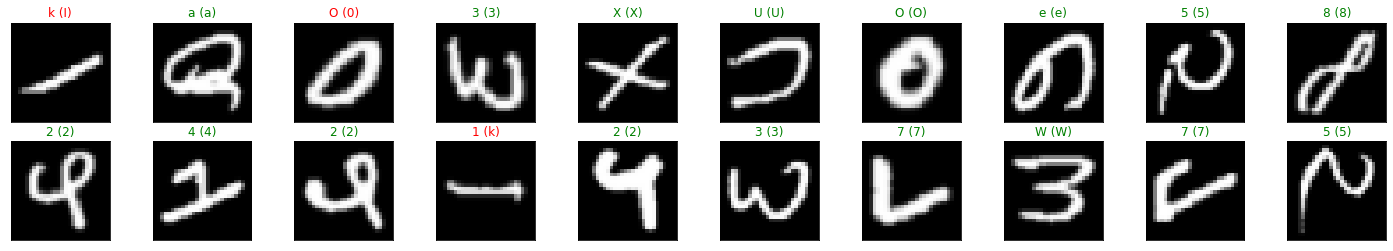

In [59]:
dataiter = iter(test_loader)
images , labels = dataiter.next()

images = images.cuda()
labels = labels.cuda()
output = model(images)
_, preds = torch.max(output, 1)
images = torch.Tensor.cpu(images).numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(
        str(str(preds[idx].item()) if preds[idx]<10 else letters[preds[idx].item()]),
        str(str(labels[idx].item()) if labels[idx]<10 else letters[labels[idx].item()])), 
        color = ("green" if preds[idx] == labels[idx] else "red"))